### EDA

In [18]:
from zipfile import ZipFile

# Import neccessary support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2, os
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

from sklearn.utils import shuffle

# load VGG-16 model: 23 layers, 138,357,544 params, 528MB
from keras.applications.vgg16 import VGG16
# These models expect 
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [2]:
# Load Image ID's from text file
with open('../data/dog_data_part2.txt', 'r') as imagehandles:
    # Store Image ID's as variable for image pre-processing, removing the endline character in the process
    dog_data_part2 = [image_id[:-1] for image_id in imagehandles]
# Check that all is copacetic
len(dog_data_part2), type(dog_data_part2), dog_data_part2[0], type(dog_data_part2[0])

(1240, list, '2377385', str)

### Instantiate VGG-16 Model
> * Image data format set in Keras config file at  '~/.keras/keras.json'
{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_last" # "Height-Width-Depth" TensorFlow data format convention
}

In [3]:
#Vizualize filters and feature maps of CNNs with VGG-16
# load VGG-16 model: 23 layers, 138,357,544 params, 528MB
from keras.applications.vgg16 import VGG16

# Adjust input size of the model for include_top=False
# new_input = Input(shape=(224,224,3)) --> MUST INCLUDE THIS PARAM AFTER CLASSIFICATION

# load the model weights into memory
# https://keras.io/api/applications/vgg/#vgg16-function
model_vgg16 = VGG16(
                include_top=True,   # include_top=False to load model wihtout the fully-connected output layers used to make predictions
                weights="imagenet", # Weights are downloaded automatically when instantiating a model: Keras Applications ~/.keras/models/
                input_tensor=None,  # input_tensor = new_input = Input(shape=(224,224,3))
                input_shape=None,
                pooling=None,
                classes=1000,
                classifier_activation="softmax",
            )
# Summarize the loaded model
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [310]:
# VGG-16 Layers with non-zero parameters
layers_VGG16 = [1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17, 20, 21, 22]

# summarize filter shapes
print('Layer Summary\tKernel Size: ( K x K )\t')
print()
print('Number\t\tName\t\t(K, K, Depth, Nodes)')
layer_VGG16 = 0
# Loop thru each layer in ImageNet Model to summarize
for layer in model_vgg16.layers:
    # check for convolutional layer
    if ('conv' not in layer.name) & ('fc' not in layer.name):
        layer_VGG16 += 1
        continue # Exclude fully connected layers & return to loop beginning
    # get filter weights
    filters, biases = layer.get_weights()
    print(f'Layer {layer_VGG16}:\t{layer.name}\t{filters.shape}')
    layer_VGG16 += 1
print()

# Select layer from VGG-16 layers list above to retrieve weights
layer_number = layers_VGG16[3]
# Retrieve current weights from selected hidden layer: 'layer_number'
# Weights rep state of layer, get_weights loads state into similarly parameterized layers
filters_extract, biases_extract = model_vgg16.layers[layer_number].get_weights()
print(f'Layer {layer_number}: {filters_extract.shape}')

Layer Summary	Kernel Size: ( K x K )	

Number		Name		(K, K, Depth, Nodes)
Layer 1:	block1_conv1	(3, 3, 3, 64)
Layer 2:	block1_conv2	(3, 3, 64, 64)
Layer 4:	block2_conv1	(3, 3, 64, 128)
Layer 5:	block2_conv2	(3, 3, 128, 128)
Layer 7:	block3_conv1	(3, 3, 128, 256)
Layer 8:	block3_conv2	(3, 3, 256, 256)
Layer 9:	block3_conv3	(3, 3, 256, 256)
Layer 11:	block4_conv1	(3, 3, 256, 512)
Layer 12:	block4_conv2	(3, 3, 512, 512)
Layer 13:	block4_conv3	(3, 3, 512, 512)
Layer 15:	block5_conv1	(3, 3, 512, 512)
Layer 16:	block5_conv2	(3, 3, 512, 512)
Layer 17:	block5_conv3	(3, 3, 512, 512)
Layer 20:	fc1	(25088, 4096)
Layer 21:	fc2	(4096, 4096)

Layer 5: (3, 3, 128, 128)


In [336]:
filters[0][0][0].shape, type(filters[0][0][0])

((64,), numpy.ndarray)

In [329]:
filters[0][0].shape, type(filters[0][0])

((3, 64), numpy.ndarray)

In [332]:
filters[0].shape, type(filters[0])

((3, 3, 64), numpy.ndarray)

In [327]:
filters.shape, type(filters)

((3, 3, 3, 64), numpy.ndarray)

		 FILTER #


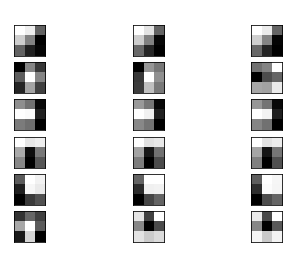

In [6]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix, fc='grey')
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            c = '\nBLUE'
        elif j == 1:
            c = '\nGREEN'
        else:
            c ='\nRED'
        plt.xlabel(xlabel=c,color='w')
        plt.ylabel(ylabel=f'  \n\n{i+1}',color='w',rotation=0)
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
print('\t\t FILTER #')

In [7]:
dog_data_part2;

In [8]:
img_path = '../../visual_genome_part2/VG_100K_2/2405343.jpg'
img = image.load_img(img_path, target_size=(224, 224))
dog_x = image.img_to_array(img)
dog_x = np.expand_dims(dog_x, axis=0)
dog_x = preprocess_input(dog_x)

In [133]:
# Extract features from image_id = dog_x with VGG-16
preds = model_vgg16.predict(dog_x)

# Decode extracted features into class, description, and probability

preds_class_breed_score = decode_predictions(preds, top=5)[0]
print('Prediction: \n')
for i in range(len(preds_class_breed_score)):
    print(f'\t{preds_class_breed_score[i][2]*100:.2f}%\t:{preds_class_breed_score[i][1]}')

Prediction: 

	37.11%	:keeshond
	13.47%	:schipperke
	8.45%	:Newfoundland
	7.30%	:groenendael
	6.35%	:Norwegian_elkhound


In [129]:
decode_predictions(preds, top=25)[0]

[('n02112350', 'keeshond', 0.37105247),
 ('n02104365', 'schipperke', 0.13470888),
 ('n02111277', 'Newfoundland', 0.0845376),
 ('n02105056', 'groenendael', 0.073017746),
 ('n02091467', 'Norwegian_elkhound', 0.06352974),
 ('n02500267', 'indri', 0.03845513),
 ('n02445715', 'skunk', 0.035748463),
 ('n02108551', 'Tibetan_mastiff', 0.032140084),
 ('n02106662', 'German_shepherd', 0.01633126),
 ('n02106382', 'Bouvier_des_Flandres', 0.010834407),
 ('n02106166', 'Border_collie', 0.009284958),
 ('n02110063', 'malamute', 0.00925284),
 ('n02110185', 'Siberian_husky', 0.0068449895),
 ('n03404251', 'fur_coat', 0.006372816),
 ('n02099267', 'flat-coated_retriever', 0.004811044),
 ('n02112137', 'chow', 0.0047492017),
 ('n02105412', 'kelpie', 0.004737555),
 ('n02112018', 'Pomeranian', 0.0045249825),
 ('n02111129', 'Leonberg', 0.00441722),
 ('n02109961', 'Eskimo_dog', 0.004194549),
 ('n02114367', 'timber_wolf', 0.0029230756),
 ('n02133161', 'American_black_bear', 0.0027088977),
 ('n02817516', 'bearskin', 

In [10]:
# NOTICE CODE FROM
# https://thispointer.com/python-how-to-get-the-list-of-all-files-in-a-zip-archive/
img_path = '../../visual_genome_part2/VG_100K_2/2405343.jpg'

# Save image in set directory 
# Load RGB image 
img = cv2.imread(img_path)
print( img.shape, type(img))
# Read image binary data of 'VG_100K_2' from zip archive('visual_genome_part2.zip')
#in_bytes = z.read(ith_image)
# Decode bytes to image
#img = cv2.imdecode(np.frombuffer(in_bytes, np.uint8), cv2.IMREAD_COLOR)
img = preprocess_input(img)
print( img.shape, type(img))
# Output img with window name as 'image' 
cv2.imshow('img', img)
# Display for 1sec = 1_000ms
#cv2.waitKey(1000)

#cv2.destroyAllWindows()

(500, 400, 3) <class 'numpy.ndarray'>
(500, 400, 3) <class 'numpy.ndarray'>


In [134]:
# NOTICE CODE FROM
# https://thispointer.com/python-how-to-get-the-list-of-all-files-in-a-zip-archive/

# ~5.5 GB ZIP Archive, 40% of total data set
with ZipFile('../../visual_genome_part2.zip', "r") as z:
    # One file in zip archive
    VG_100K_2 = z.namelist()

    # Iterate over image file names, 'VG_100K_2/image_id.jpg'
    for ith_image in VG_100K_2: 
        # Get extension of file, '.jpg'
        ext = os.path.splitext(ith_image)[-1]
        # Get root of file, root = VG_100K_2/image_id.jpg
        root = os.path.splitext(ith_image)[0]
        
        # Skip over Archive Directory
        if (ext == ".jpg"):
            # Skip root[:10]='VG_100K_2' in dog_pic_ids
            if int(root[10:]) == 2405343:
                # Read image binary data of 'VG_100K_2' from zip archive('visual_genome_part2.zip')
                in_bytes = z.read(ith_image) # VG_100K_2/
                # Decode bytes to image
                img = cv2.imdecode(np.frombuffer(in_bytes, np.uint8), cv2.IMREAD_COLOR)
    
                # Output img with window name as 'image' 
                cv2.imshow('img', img)
                # Display for 1sec = 1_000ms
                cv2.waitKey(30*1000)

cv2.destroyAllWindows()

In [11]:
#model.save('/../assets/model.h5')

print("Saved model to disk")
#del model

Saved model to disk


In [12]:
type(img)

numpy.ndarray

In [13]:
len(img)

500

In [14]:
img.shape

(500, 400, 3)

In [15]:
26000/13

2000.0

In [16]:
2000*52

104000